In [1]:
import os
from collections import OrderedDict
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import glob

from scipy.stats import ttest_ind as tt
from scipy.stats import wilcoxon, spearmanr, permutation_test
import scanpy as sc
import anndata as ad

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(5,5), frameon=False)

In [2]:
run_name = "Graph-Perciever_September-17"
fold_idx = 2
features_path = os.path.join("/SeaExp/Rushin/TNTA/logs/", run_name+"_fold_{}".format(fold_idx))
metadata_path = os.path.join("/SeaExp/Rushin/datasets/", "CIS", "idr0082-experimentA-annotation.csv")

In [3]:
all_adata = sc.read_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))
all_adata.obs.loc[all_adata.obs['labels'] == 'cis','bulk_labels'] = 'cis'
cis_adata = all_adata.copy()
cis_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [4]:
cis_adata.obs['cohort_names'].unique()

['CPTAC', 'Pennycuick', 'Roswell']
Categories (3, object): ['Pennycuick', 'CPTAC', 'Roswell']

In [5]:
cis_metadata = pd.read_csv(metadata_path, header=0)
cis_metadata = cis_metadata[cis_metadata['Dataset Name'] == 'Lung Carcinoma']
cis_metadata['name'] = cis_metadata['Source Name'] + '_HandE'
cis_metadata = cis_metadata[['name', 'Characteristics [Phenotype Outcome]', 'Characteristics [Smoking Status]', 'Characteristics [Previous Lung Cancer]', 'CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'CIS - Area', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells', 'Stroma - Area']]

cis_metadata = cis_metadata.rename(columns={'Characteristics [Phenotype Outcome]': 'progression_status', 
                                            'Characteristics [Smoking Status]': 'smoking_status',
                                            'Characteristics [Previous Lung Cancer]': 'cancer_history'})

cis_metadata.index = cis_metadata['name']
del cis_metadata['name']
cis_metadata.head()

,progression_status,smoking_status,cancer_history,CIS - Lymphocytes,CIS - Stromals,CIS - Tumors,CIS - Other Cells,CIS - Area,Stroma - Lymphocytes,Stroma - Stromals,Stroma - Tumors,Stroma - Other Cells,Stroma - Area
name,,,,,,,,,,,,,
S1_HandE,Progression,Unknown,False,1059,293,15358,2424,1.177354e+07,2097.0,393.0,5336.0,2171.0,5820278.750
S11_HandE,Progression,Former,True,1040,334,3422,274,2.777588e+06,2071.0,1107.0,3707.0,649.0,4936471.125
S12_HandE,Progression,Former,True,160,68,1917,138,1.249441e+06,2501.0,774.0,2119.0,321.0,3102706.000
S13_HandE,Progression,Former,True,321,36,689,230,5.528935e+05,1334.0,31.0,433.0,512.0,1028434.250
S133_HandE,Regression,Former,False,780,18,1089,151,9.669014e+05,620.0,353.0,924.0,442.0,2093952.625


In [6]:
q = cis_adata[cis_adata.obs['cohort_names'] == 'Pennycuick']
cis_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [7]:
q = cis_adata[cis_adata.obs['cohort_names'] == 'Pennycuick']
cis_sample_names = q.obs_names
for col in cis_metadata.columns:
    cis_adata.obs[col] = cis_metadata.loc[cis_sample_names, col]
cis_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'progression_status', 'smoking_status', 'cancer_history', 'CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'CIS - Area', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells', 'Stroma - Area'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [8]:
cis_adata.obs['labels']

Slide_Name
C3L-02660-26                           normal
C3N-00572-26                           normal
C3L-01884-26                           normal
C3N-02158-27                           normal
C3N-02434-27                           normal
                                     ...     
PCGA-01-0052-048-20842-01017BX      dysplasia
PCGA-01-0052-048-21157-01302BX    hyperplasia
PCGA-01-0052-050-20842-01015BX      dysplasia
PCGA-01-0052-093-20842-01014BX      dysplasia
PCGA-01-0052-093-21157-01299BX     pml_normal
Name: labels, Length: 2529, dtype: category
Categories (8, object): ['cis', 'dysplasia', 'hyperplasia', 'luad', 'lusc', 'metaplasia', 'normal', 'pml_normal']

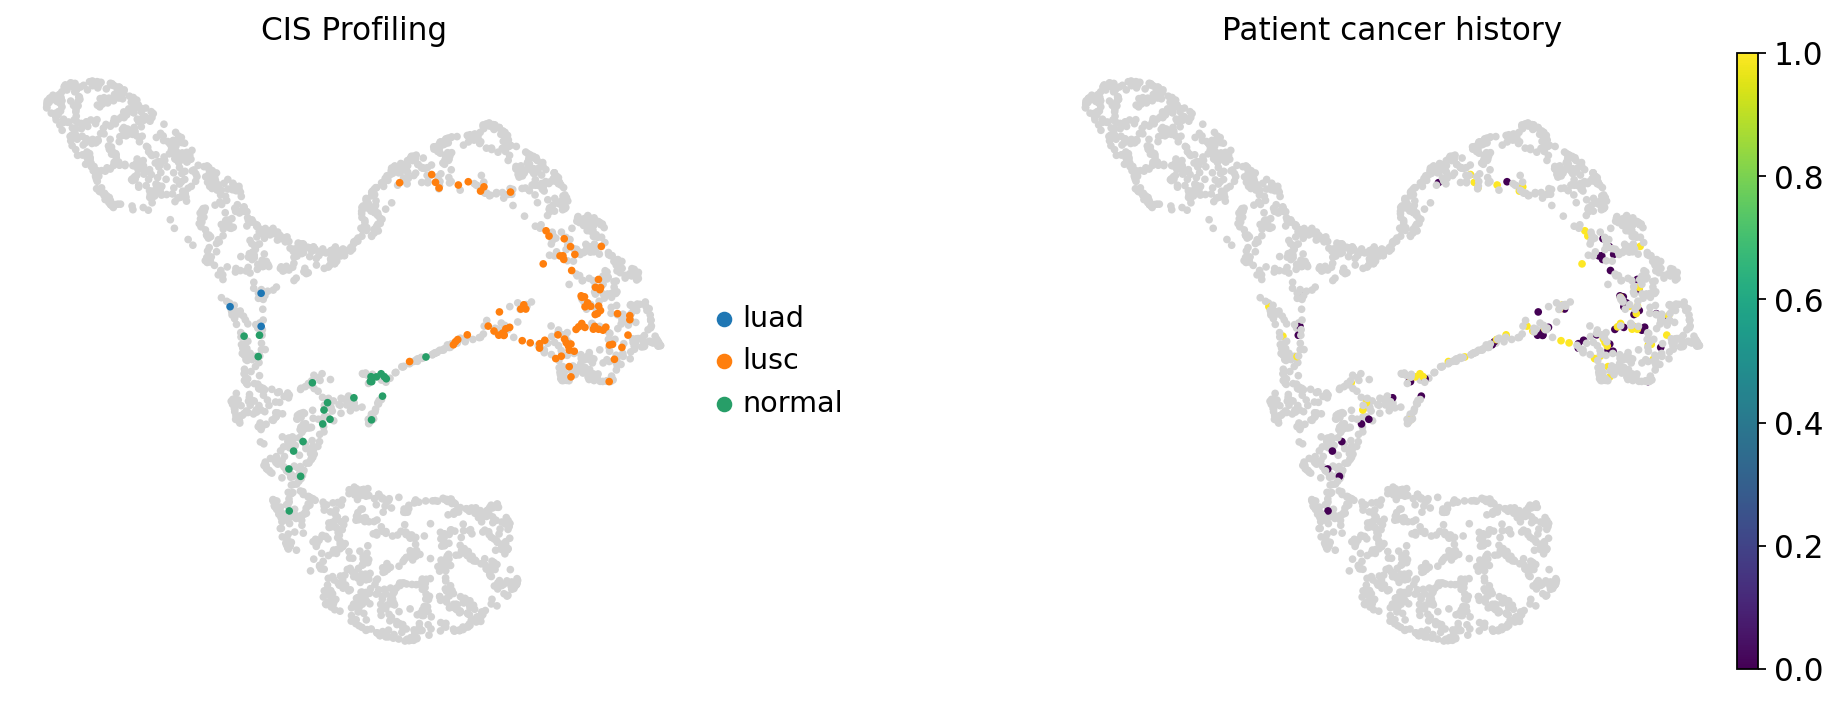

In [9]:
# Model Predictions for CIS samples
cis_model_predictions = cis_adata.copy()
cis_model_predictions.obs.loc[cis_model_predictions.obs['cohort_names']!='Pennycuick', 'model_predictions'] = np.nan

# with plt.rc_context({'figure.figsize': (4, 8)}):
sc.pl.umap(cis_model_predictions, color=['model_predictions', 'cancer_history'], title=['CIS Profiling', 'Patient cancer history'], frameon=False, wspace=0.4, na_in_legend=False)

PC1 T-Test:  2.8186066300437553 0.005720912044154095
PC2 T-Test:  -4.589882668573802 1.1839401080007017e-05


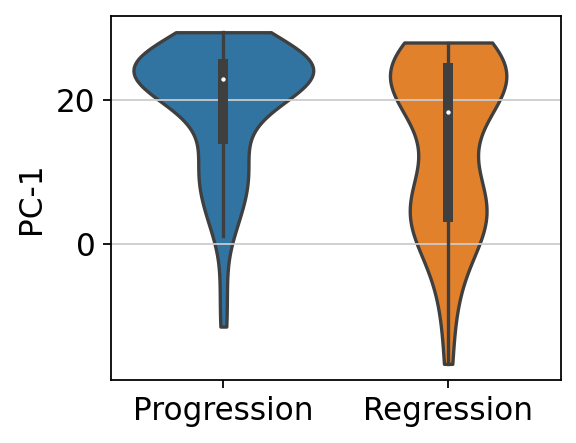

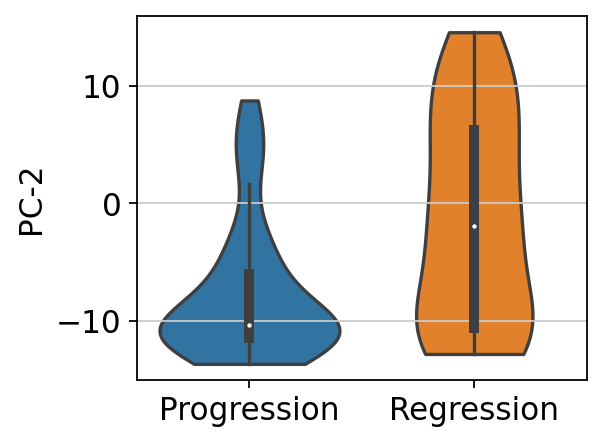

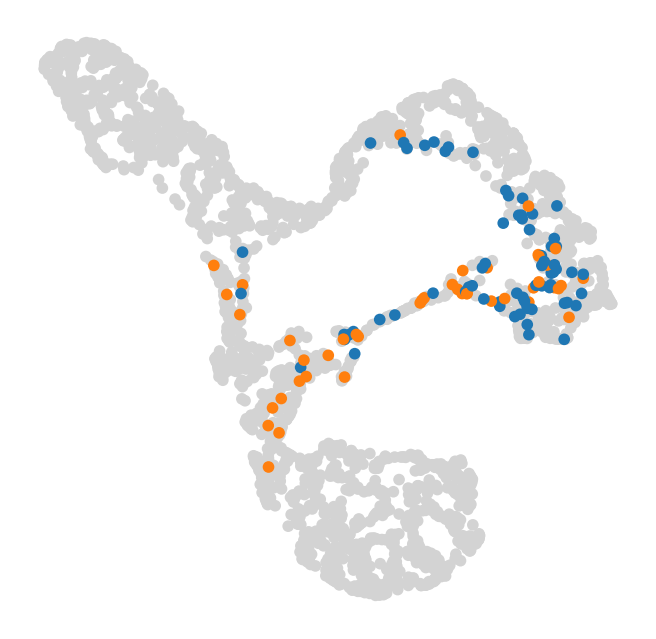

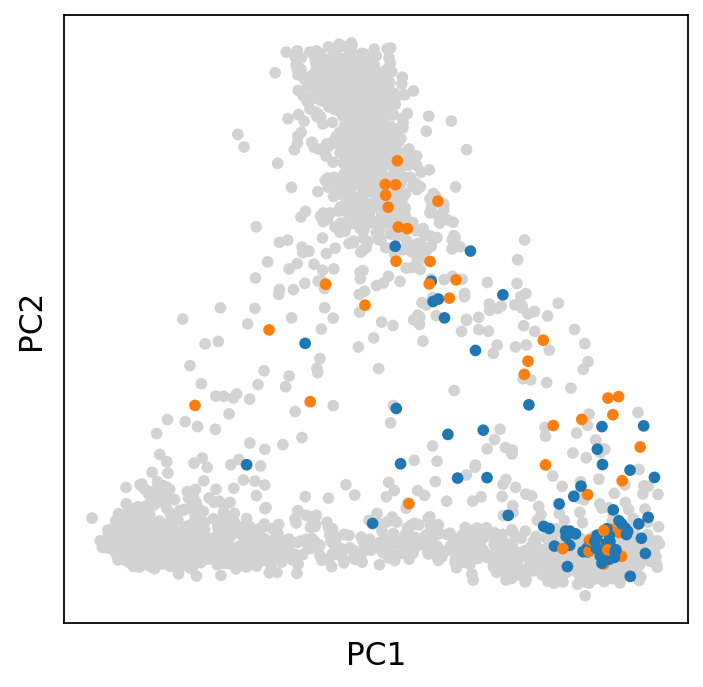

In [10]:
# Progression Status Plots and Scores

cis_adata.obs['pc1'] = cis_adata.obsm['X_pca'][:, 0]
cis_adata.obs['pc2'] = cis_adata.obsm['X_pca'][:, 1]

progressors = cis_adata[cis_adata.obs.progression_status == 'Progression']
regressors = cis_adata[cis_adata.obs.progression_status == 'Regression']

statistic, p_value = tt(progressors.obs.pc1, regressors.obs.pc1)
print("PC1 T-Test: ", statistic, p_value)

statistic, p_value = tt(progressors.obs.pc2, regressors.obs.pc2)
print("PC2 T-Test: ", statistic, p_value)

with rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(cis_adata, keys = ['pc1'], groupby='progression_status', stripplot=False, inner='box', scale='count', ylabel=['PC-1'], xlabel=None, save='_cis_progressors_pc1.pdf') 

with rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(cis_adata, keys = ['pc2'], groupby='progression_status', stripplot=False, inner='box', scale='count', ylabel=['PC-2'], xlabel=None, save='_cis_progressors_pc2.pdf')

# Progressors v Regressors UMAP
# with plt.rc_context({'figure.figsize': (4, 4)}):
sc.pl.umap(cis_adata, color=['progression_status'], title=[''], frameon=False, wspace=0.4, na_in_legend=False, s=110, legend_loc=None, save='_cis_progression_status.pdf')
# with plt.rc_context({'figure.figsize': (4, 4)}):
sc.pl.pca(cis_adata, color=['progression_status'], title=[''], frameon=True, wspace=0.4, na_in_legend=False, legend_loc=None, s=110, save='_cis_progression_status.pdf')    

In [11]:
# Lymphocytes, Stromal & Tumor Content plots and scores
# cis_adata.obs['CIS - Lymphocytes']

# cis_adata = cis_adata[cis_adata.obs.cohort_names == 'CIS']
cis_adata.obs['CIS - Lymphocytes'] = cis_adata.obs['CIS - Lymphocytes'] / cis_adata.obs['CIS - Area']
cis_adata.obs['CIS - Stromals'] = cis_adata.obs['CIS - Stromals'] / cis_adata.obs['CIS - Area']
cis_adata.obs['CIS - Tumors'] = cis_adata.obs['CIS - Tumors'] / cis_adata.obs['CIS - Area']
cis_adata.obs['CIS - Other Cells'] = cis_adata.obs['CIS - Other Cells'] / cis_adata.obs['CIS - Area']

cis_adata.obs['Stroma - Lymphocytes'] = cis_adata.obs['Stroma - Lymphocytes'] / cis_adata.obs['Stroma - Area']
cis_adata.obs['Stroma - Stromals'] = cis_adata.obs['Stroma - Stromals'] / cis_adata.obs['Stroma - Area']
cis_adata.obs['Stroma - Tumors'] = cis_adata.obs['Stroma - Tumors'] / cis_adata.obs['Stroma - Area']
cis_adata.obs['Stroma - Other Cells'] = cis_adata.obs['Stroma - Other Cells'] / cis_adata.obs['Stroma - Area']

# cis_adata.obs[['CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells']].head()

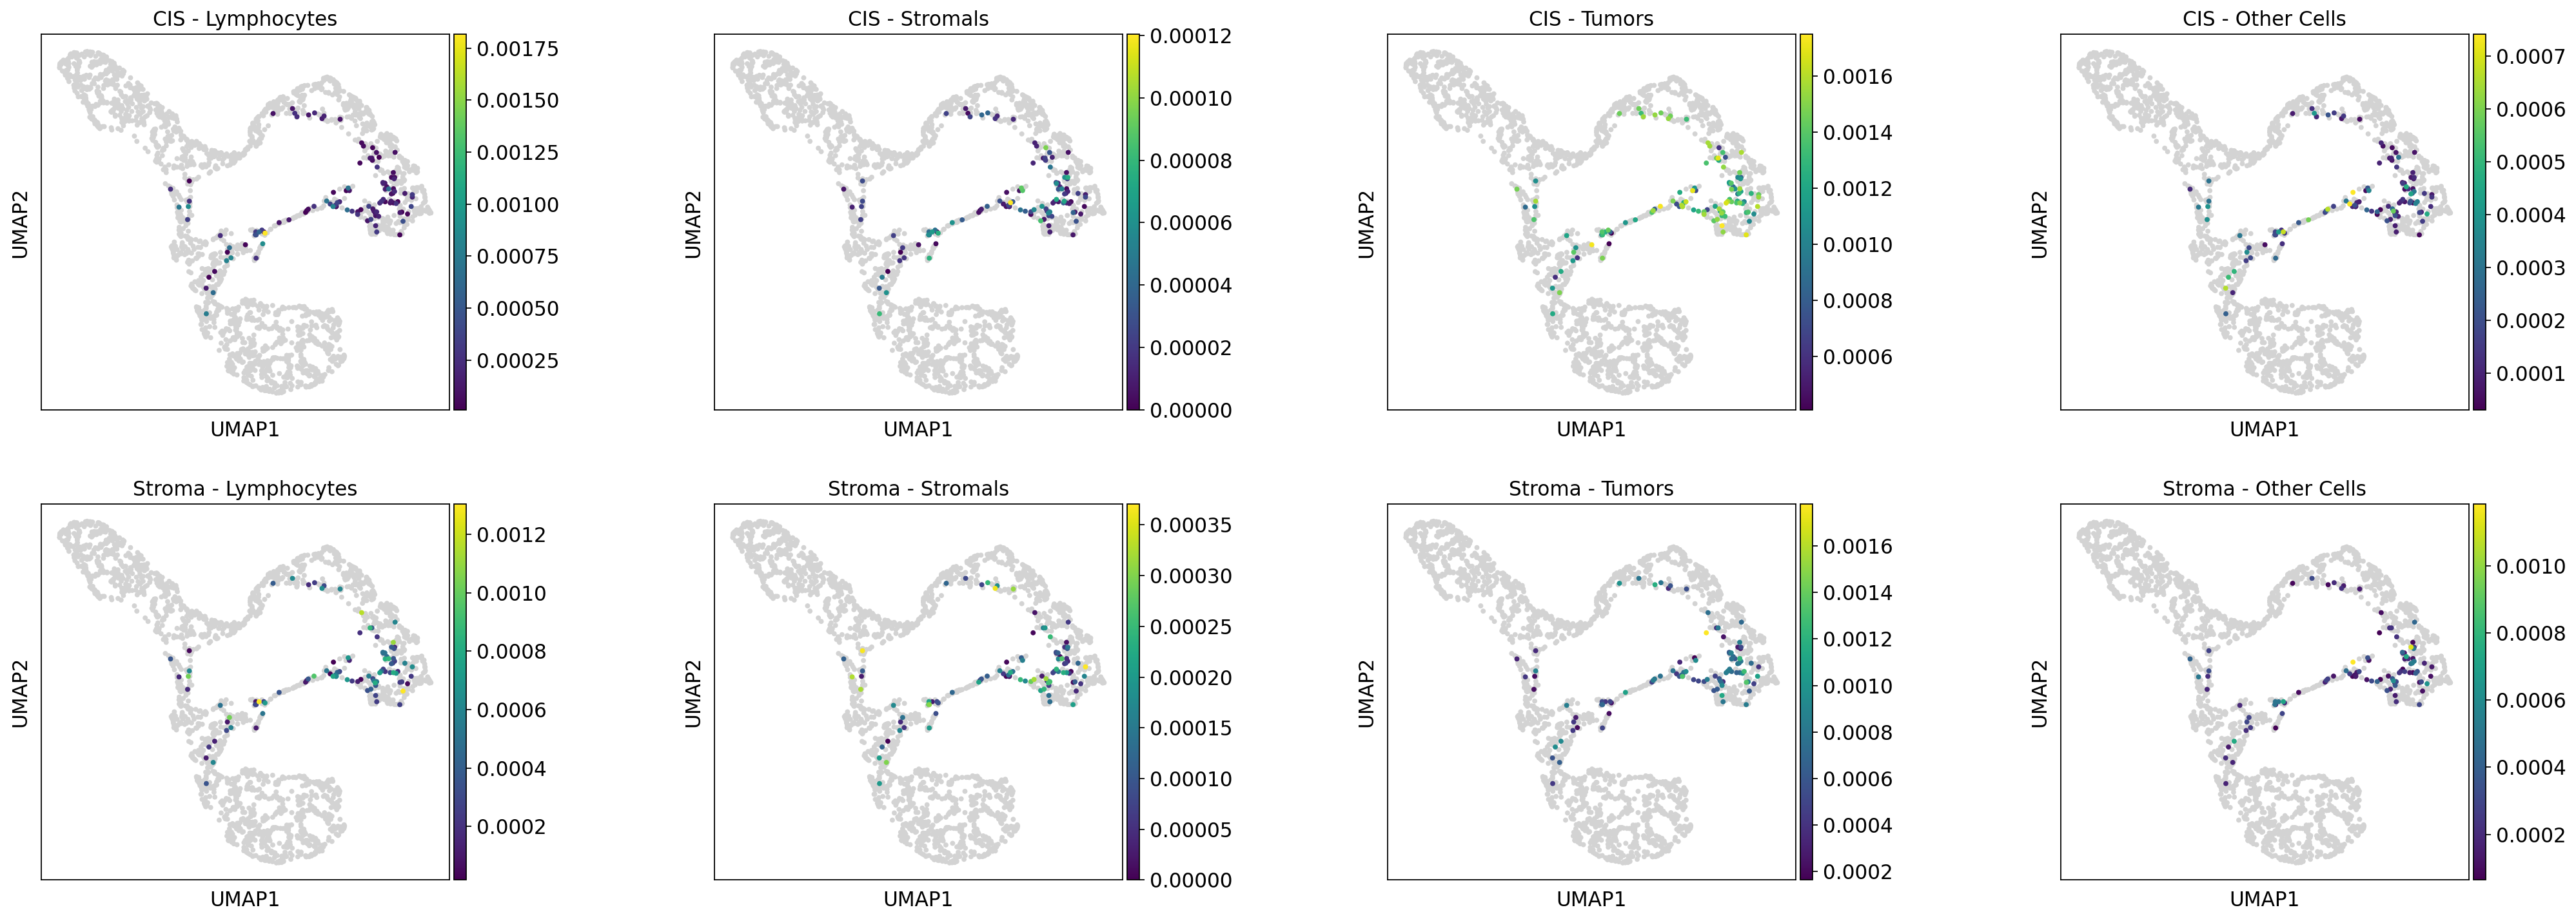

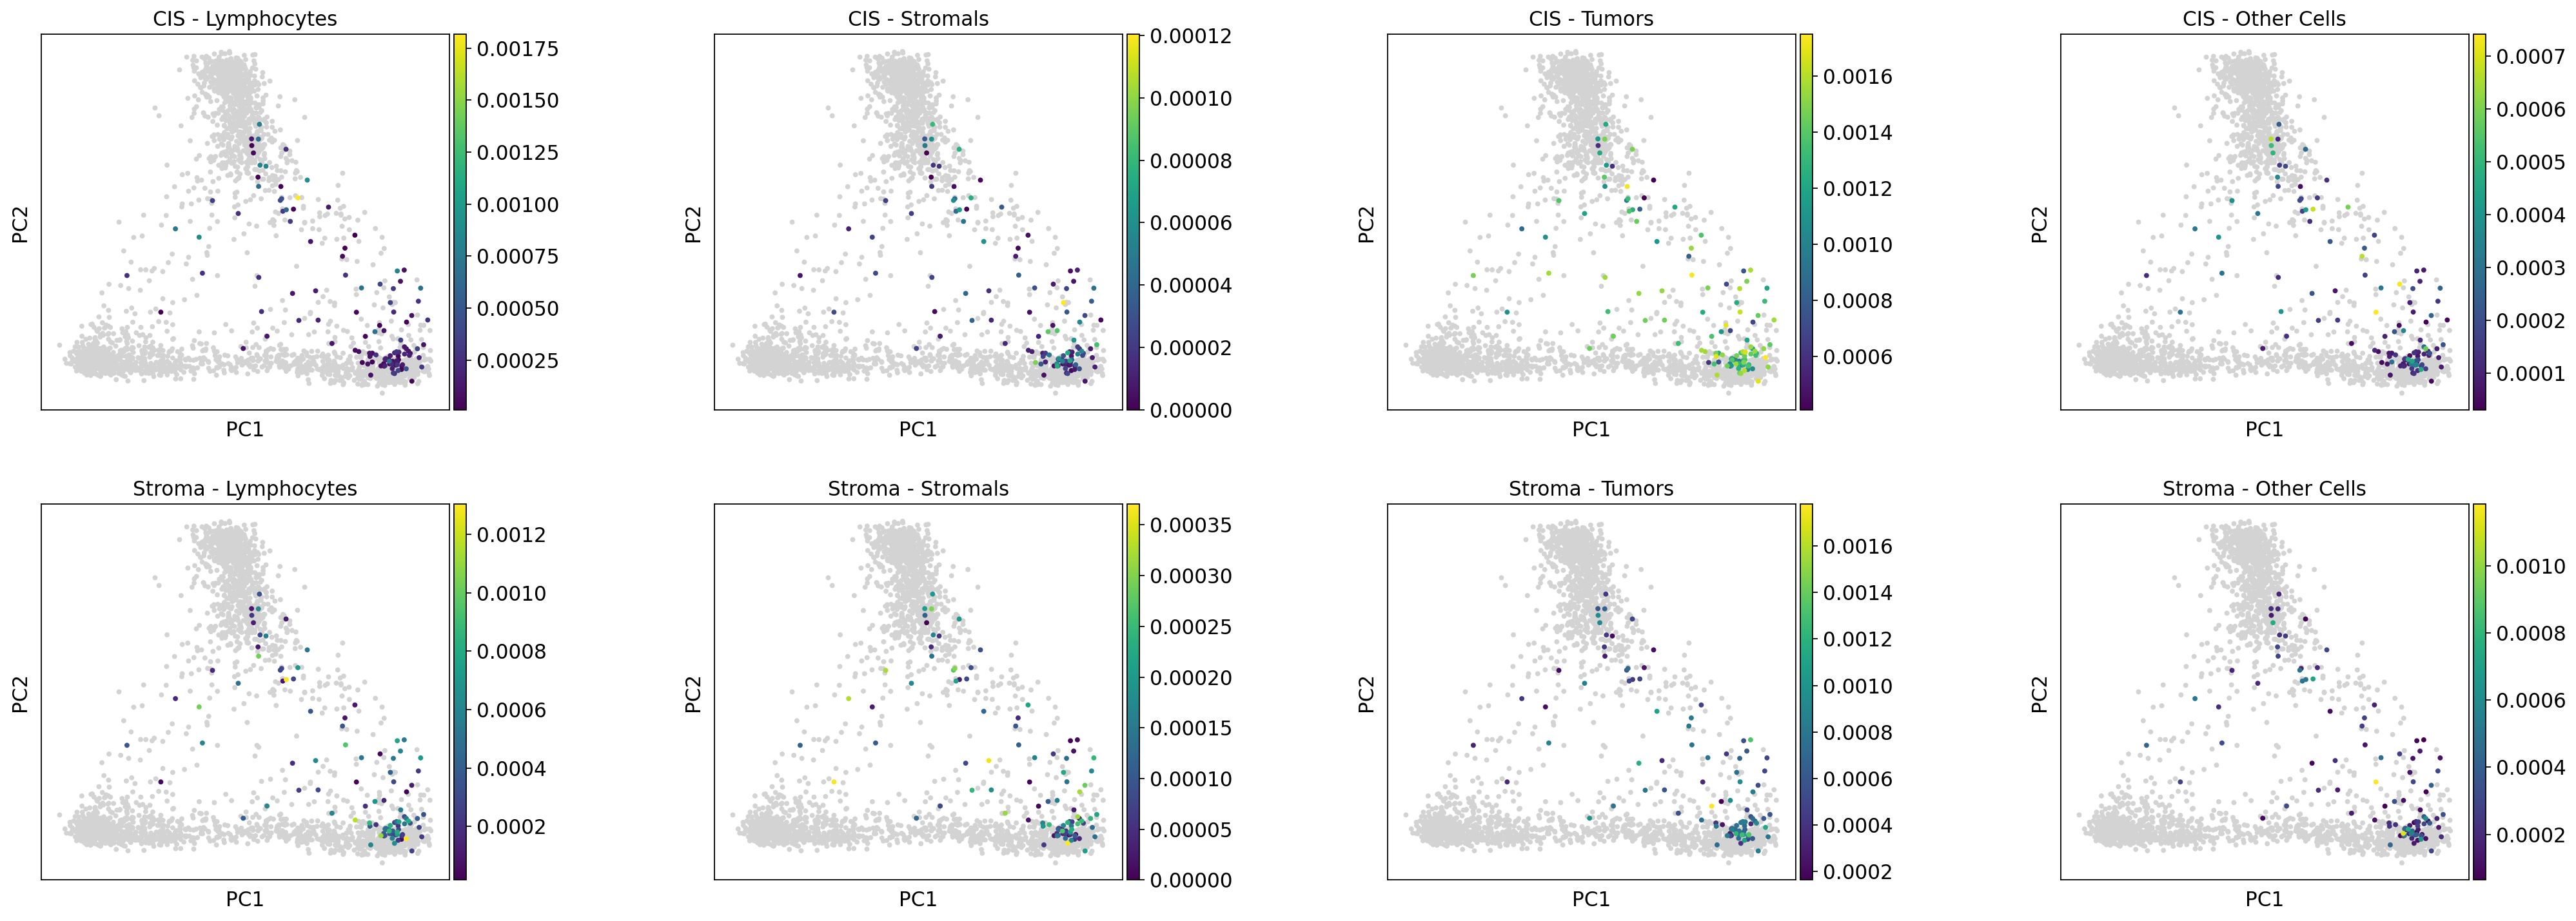

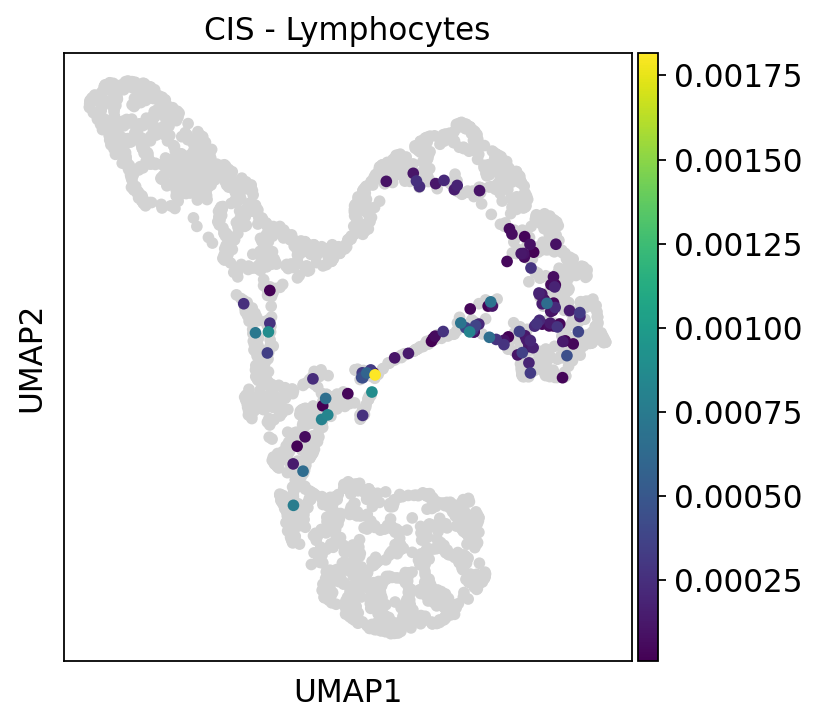

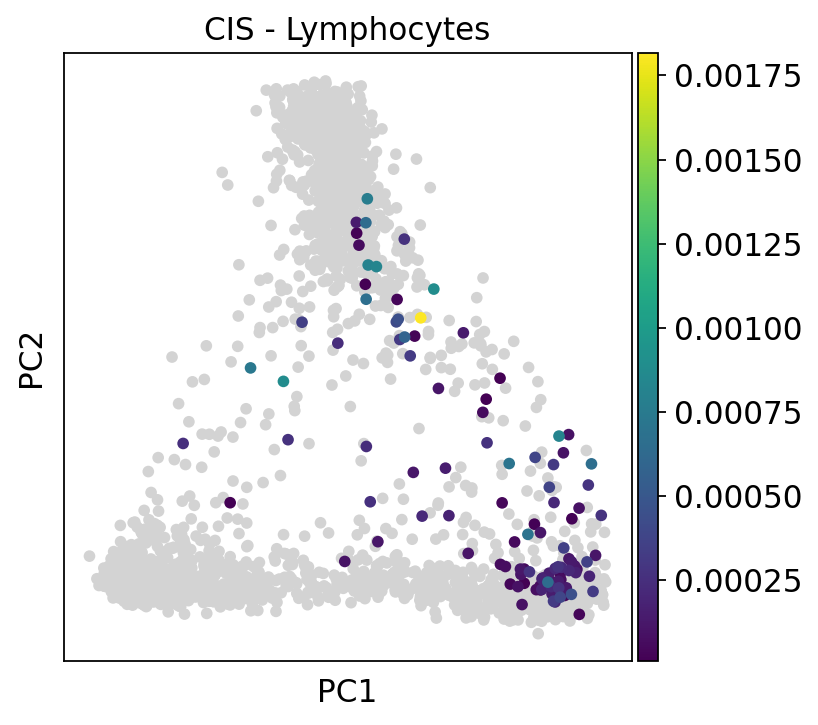

In [12]:
sc.pl.umap(cis_adata, color=['CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells'], na_in_legend=False, legend_fontsize='large', size=50, frameon=True, wspace=0.5, save='penny-cell-counts.pdf')
sc.pl.pca(cis_adata, color=['CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells'], na_in_legend=False, legend_fontsize='large', size=50, frameon=True, wspace=0.5, save='penny-cell-counts.pdf')

sc.pl.umap(cis_adata, color=['CIS - Lymphocytes'], na_in_legend=False, legend_fontsize='large', size=50, frameon=True, wspace=0.5, s=110, save='_cis_lymphocytes.pdf')
sc.pl.pca(cis_adata, color=['CIS - Lymphocytes'], na_in_legend=False, legend_fontsize='large', size=50, frameon=True, wspace=0.5, s=110, save='_cis_lymphocytes.pdf')

In [23]:
progressors = cis_adata[cis_adata.obs.progression_status == 'Progression']
regressors = cis_adata[cis_adata.obs.progression_status == 'Regression']

statistic, p_value = tt(progressors.obs['CIS - Lymphocytes'], regressors.obs['CIS - Lymphocytes'])
print("Lymphocytes cell counts T Test (Progressive V Regressive): ", statistic, p_value)

cis_samples = cis_adata[cis_adata.obs.cohort_names == 'Pennycuick']

def statistic_progressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_progressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((progressors.obs['CIS - Lymphocytes'],), statistic_progressors_pc1, permutation_type='pairings')
print("Progressive CIS-Lymphocytes spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((progressors.obs['CIS - Lymphocytes'],), statistic_progressors_pc2, permutation_type='pairings')
print("Progressive CIS-Lymphocytes spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)

def statistic_regressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_regressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((regressors.obs['CIS - Lymphocytes'],), statistic_regressors_pc1, permutation_type='pairings')
print("Regressive Lymphocytes cell counts spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((regressors.obs['CIS - Lymphocytes'],), statistic_regressors_pc2, permutation_type='pairings')
print("Regressive Lymphocytes cell counts spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)


Lymphocytes cell counts T Test (Progressive V Regressive):  -2.370322291416749 0.01951350555543218


Progressive CIS-Lymphocytes spearman correlation with PC1:  0.0003053784784517311 0.9928
Progressive CIS-Lymphocytes spearman correlation with PC2:  0.40203076688170397 0.0006
Regressive Lymphocytes cell counts spearman correlation with PC1:  -0.17533474277660324 0.2548
Regressive Lymphocytes cell counts spearman correlation with PC2:  0.18167723749119094 0.2348


In [24]:
progressors = cis_adata[cis_adata.obs.progression_status == 'Progression']
regressors = cis_adata[cis_adata.obs.progression_status == 'Regression']

statistic, p_value = tt(progressors.obs['CIS - Stromals'], regressors.obs['CIS - Stromals'])
print("Stromals cell counts T Test (Progressive V Regressive): ", statistic, p_value)

cis_samples = cis_adata[cis_adata.obs.cohort_names == 'Pennycuick']

def statistic_progressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_progressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((progressors.obs['CIS - Stromals'],), statistic_progressors_pc1, permutation_type='pairings')
print("Progressive CIS - Stromals spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((progressors.obs['CIS - Stromals'],), statistic_progressors_pc2, permutation_type='pairings')
print("Progressive CIS - Stromals spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)

def statistic_regressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_regressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((regressors.obs['CIS - Stromals'],), statistic_regressors_pc1, permutation_type='pairings')
print("Regressive Stromals cell counts spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((regressors.obs['CIS - Stromals'],), statistic_regressors_pc2, permutation_type='pairings')
print("Regressive Stromals cell counts spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)



Stromals cell counts T Test (Progressive V Regressive):  -0.009622892159392058 0.9923395920646383
Progressive CIS - Stromals spearman correlation with PC1:  -0.08420811543306486 0.4996
Progressive CIS - Stromals spearman correlation with PC2:  0.2972859487727602 0.013
Regressive Stromals cell counts spearman correlation with PC1:  0.030726946000259613 0.8282
Regressive Stromals cell counts spearman correlation with PC2:  0.04101624443153921 0.796


In [25]:
progressors = cis_adata[cis_adata.obs.progression_status == 'Progression']
regressors = cis_adata[cis_adata.obs.progression_status == 'Regression']

statistic, p_value = tt(progressors.obs['CIS - Tumors'], regressors.obs['CIS - Tumors'])
print("Tumors cell counts T Test (Progressive V Regressive): ", statistic, p_value)

cis_samples = cis_adata[cis_adata.obs.cohort_names == 'Pennycuick']

def statistic_progressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_progressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((progressors.obs['CIS - Tumors'],), statistic_progressors_pc1, permutation_type='pairings')
print("Progressive CIS - Tumors spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((progressors.obs['CIS - Tumors'],), statistic_progressors_pc2, permutation_type='pairings')
print("Progressive CIS - Tumors spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)

def statistic_regressors_pc1(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc1']).statistic
    # print(stat)
    return stat

def statistic_regressors_pc2(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc2']).statistic
    # print(stat)
    return stat

res_exact = permutation_test((regressors.obs['CIS - Tumors'],), statistic_regressors_pc1, permutation_type='pairings')
print("Regressive Tumors cell counts spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

res_exact = permutation_test((regressors.obs['CIS - Tumors'],), statistic_regressors_pc2, permutation_type='pairings')
print("Regressive Tumors cell counts spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)


Tumors cell counts T Test (Progressive V Regressive):  2.866355793671161 0.004976611886394411
Progressive CIS - Tumors spearman correlation with PC1:  0.13387029049127763 0.2886
Progressive CIS - Tumors spearman correlation with PC2:  0.0033591632629690416 0.9598
Regressive Tumors cell counts spearman correlation with PC1:  0.06412966878083157 0.6712
Regressive Tumors cell counts spearman correlation with PC2:  -0.11346018322762508 0.4684


In [15]:
progressors = cis_adata[cis_adata.obs.progression_status == 'Progression']
regressors = cis_adata[cis_adata.obs.progression_status == 'Regression']

statistic, p_value = tt(progressors.obs['Stroma - Lymphocytes'], regressors.obs['Stroma - Lymphocytes'], nan_policy='omit')
print("Lymphocytes cell counts T Test (Progressive V Regressive): ", statistic, p_value)

cis_samples = cis_adata[cis_adata.obs.cohort_names == 'Pennycuick']

def statistic_pc1(x):  # permute only `x`
    stat = spearmanr(x, cis_samples.obs['pc1'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((cis_samples.obs['Stroma - Area'],), statistic_pc1, permutation_type='pairings')
print("Stroma-area spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)

def statistic_pc2(x):  # permute only `x`
    stat = spearmanr(x, cis_samples.obs['pc2'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((cis_samples.obs['Stroma - Area'],), statistic_pc2, permutation_type='pairings')
print("Stroma-area spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)

def statistic_pc1(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc1'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((progressors.obs['Stroma - Lymphocytes'],), statistic_pc1, permutation_type='pairings')
print("Progressive Stroma Lymphocytes cell counts spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)
# statistic, p_value = spearmanr(progressors.obs['CIS - Lymphocytes'], progressors.obs['pc1'])
# print("Progressive Lymphocytes cell counts correlation with PC1: ", statistic, p_value)

def statistic_pc2(x):  # permute only `x`
    stat = spearmanr(x, progressors.obs['pc2'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((progressors.obs['Stroma - Lymphocytes'],), statistic_pc2, permutation_type='pairings')
print("Progressive Stroma Lymphocytes cell counts spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)
# statistic, p_value = spearmanr(progressors.obs['CIS - Lymphocytes'], progressors.obs['pc2'])
# print("Progressive Lymphocytes cell counts correlation with PC2: ", statistic, p_value)

print()

def statistic_pc1(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc1'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((regressors.obs['Stroma - Lymphocytes'],), statistic_pc1, permutation_type='pairings')
print("Regressive Stroma Lymphocytes cell counts spearman correlation with PC1: ", res_exact.statistic, res_exact.pvalue)
# statistic, p_value ```= spearmanr(regressors.obs['CIS - Lymphocytes'], regressors.obs['pc1'])
# print("Regressive Lymphocytes cell counts correlation with PC1: ", statistic, p_value)

def statistic_pc2(x):  # permute only `x`
    stat = spearmanr(x, regressors.obs['pc2'], nan_policy='omit').statistic
    # print(stat)
    return stat
res_exact = permutation_test((regressors.obs['Stroma - Lymphocytes'],), statistic_pc2, permutation_type='pairings')
print("Regressive Stroma Lymphocytes cell counts spearman correlation with PC2: ", res_exact.statistic, res_exact.pvalue)
# statistic, p_value = spearmanr(regressors.obs['CIS - Lymphocytes'], regressors.obs['pc2'])
# print("Regressive Lymphocytes cell counts correlation with PC2: ", statistic, p_value)


Lymphocytes cell counts T Test (Progressive V Regressive):  0.27192314226778996 0.7862712027242473
Stroma-area spearman correlation with PC1:  0.0932963391542184 0.3608
Stroma-area spearman correlation with PC2:  -0.05500473385230381 0.6198
Progressive Stroma Lymphocytes cell counts spearman correlation with PC1:  -0.09754689754689755 0.469
Progressive Stroma Lymphocytes cell counts spearman correlation with PC2:  0.15216450216450217 0.2698

Regressive Stroma Lymphocytes cell counts spearman correlation with PC1:  0.2334494773519164 0.1354
Regressive Stroma Lymphocytes cell counts spearman correlation with PC2:  -0.2900089133781703 0.0612


In [16]:
cis_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'progression_status', 'smoking_status', 'cancer_history', 'CIS - Lymphocytes', 'CIS - Stromals', 'CIS - Tumors', 'CIS - Other Cells', 'CIS - Area', 'Stroma - Lymphocytes', 'Stroma - Stromals', 'Stroma - Tumors', 'Stroma - Other Cells', 'Stroma - Area'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params', 'progression_status_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [17]:
cis_adata.obs['cancer_history'].value_counts()

True     56
False    56
Name: cancer_history, dtype: int64

In [18]:
# select cis_adata samples from CIS at bulk_labels
q = cis_adata[cis_adata.obs['cohort_names'] == 'Pennycuick']
q.obs['progression_status'].to_csv('tables/CIS_progression_status.csv')


In [19]:
cis_adata.obs['progression_status'].value_counts()

Progression    68
Regression     44
Name: progression_status, dtype: int64

In [20]:
# get cis_adata progression_status counts where model_predictions is "lusc"
q = cis_adata[cis_adata.obs['model_predictions'] == 'lusc']
print(q.obs['progression_status'].value_counts())
cis_adata[].shape


SyntaxError: invalid syntax (727715060.py, line 4)

In [ ]:
cptac_adata = all_adata[all_adata.obs.cohort_names == 'CPTAC']
cptac_luad = cptac_adata[cptac_adata.obs.labels == 'luad']
cptac_lusc = cptac_adata[cptac_adata.obs.labels == 'lusc']

print(cptac_luad)
print(cptac_lusc)

print(all_adata.obs.cohort_names.unique())

cis_adata = all_adata[all_adata.obs.cohort_names == 'Pennycuick']

cis_v_lusc_pc1, cis_v_lusc_pc1_p_value = tt(cis_adata.obs.pc1, cptac_lusc.obs.pc1)
cis_v_luad_pc1, cis_v_luad_pc1_p_value = tt(cis_adata.obs.pc1, cptac_luad.obs.pc1)

print("PML vs LUSC (PC1):",  cis_v_lusc_pc1, cis_v_lusc_pc1_p_value)
print("PML vs LUAD (PC1):",  cis_v_luad_pc1, cis_v_luad_pc1_p_value)

cis_v_lusc_pc2, cis_v_lusc_pc2_p_value = tt(cis_adata.obs.pc2, cptac_lusc.obs.pc2)
cis_v_luad_pc2, cis_v_luad_pc2_p_value = tt(cis_adata.obs.pc2, cptac_luad.obs.pc2)
print("PML vs LUSC (PC2):",  cis_v_lusc_pc2, cis_v_lusc_pc2_p_value)
print("PML vs LUAD (PC2):",  cis_v_luad_pc2, cis_v_luad_pc2_p_value)

View of AnnData object with n_obs × n_vars = 667 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 685 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'den